<a href="https://colab.research.google.com/github/KSK123123/AIFFEL_quest_cr/blob/master/MainQuest/QUEST03/MainQuest03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 참조

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 설정
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel/chest_xray/data')
TRAIN_PATH = ROOT_PATH + '/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/val/*/*'
TEST_PATH = ROOT_PATH + '/test/*/*'

In [ ]:
# 데이터 형태 확인
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

# 89 : 10.7 : 0.3
# tr : val : test

5216
624
16


In [ ]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2(train:val) 비율로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [ ]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# 폐렴(Pneumonia)의 이미지 수가 약 3배 더 많음 = 클래스 불균형

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [ ]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [ ]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [ ]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

print(f"Training images count: {TRAIN_IMG_COUNT}")
print(f"Validating images count: {VAL_IMG_COUNT}")

# 각 데이터셋 이미지 수

Training images count: 4185
Validating images count: 1047


In [ ]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다.
# 이미지 라벨링 함수
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 현실적으로 xray의 이미 사이즈는 제각각이므로
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를  [180, 180]로 통일
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [ ]:
# Train Dataset, Validation Dataset 제작
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
# 라벨링 및 크기 재조정 확인
for image, label in train_ds.take(1):  # train_ds.take(1) = 아무거나 하나 가져오기
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

# 크기[180, 180, 3], 음성(정상)

Image shape:  (180, 180, 3)
Label:  False


In [ ]:
# Test Dataset 제작

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [ ]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # shuffle()을 사용하며 고정 크기 버퍼를 유지하고
    # 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

    ds = ds.repeat()
    # repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데,
    # 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.

    ds = ds.batch(BATCH_SIZE)  # 데이터를 배치 단위로 나누기

    ds = ds.prefetch(buffer_size=AUTOTUNE)
    # prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,
    # 첫 번째 데이터를 GPU에서 학습하는 동안
    # 두 번째 데이터를 CPU에서 준비할 수 있어
    # 리소스의 유휴 상태를 줄일 수 있습니다.

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

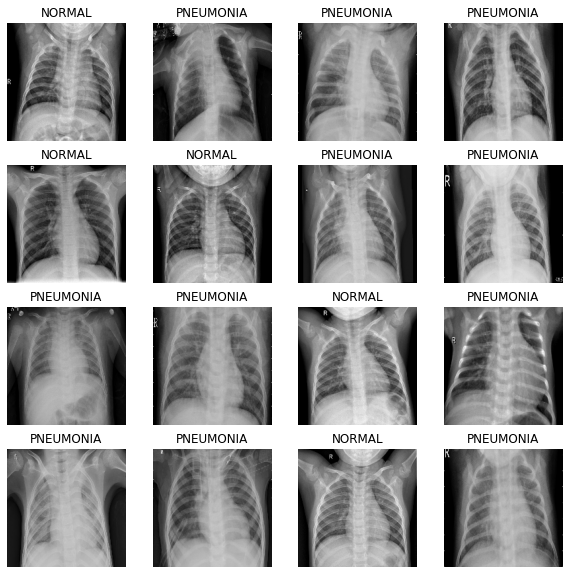

In [ ]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
# layer 설정
# Convolution layer(block)
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

# Dense layer(block)
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [ ]:
# 모델 설계
# 함수로 정의
def build_model():
    model = tf.keras.Sequential([
        # 데이터 입력단
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        # Feature Extraction
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),


        # classification (MLP)
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
Convolution layer와 Dense layer를 살펴보면
Batch Normalization, Drop out 두가지 기법이 동시에 사용되고 있음.

둘 다 성능을 높이는 것 같은데. 뭐였더라

- Batch Normalization(배치 정규화)
배치 단위로 입력된 데이터 값을 조정하는 방법
입력값들이 (-1, 1) 사이의 값을 갖도록 변환한다.

정규분포 특징
평균 = 0, 표준편차 = 1

     - 이 작업을 왜 했더라
    다양한 범위의 입력값들이 모델에 입력될 경우 학습이 더디게 진행된다고 함.
    값의 단위가 다른데 분포 형태가 같은 경우, 우리는 같은 문제로 인식하는 반면 컴퓨터는 인식하지 못한다고 함.
    GPT가 들어준 비유: 축구팀에 너무 키 큰 사람과 키 작은 사람이 섞여 있다면, 패스할 때 힘 조절이 어렵잖아요? 배치 정규화는 모든 선수의 키를 일정하게 맞춰서 패스할 때 더 정확하게 할 수 있도록 도와주는 역할을 해요.

- Dropout
학습 중 뉴런(노드)의 일부를 무작위로 비활성화하는 방법


근데 이건 사실 잘 사용하지도 않는 방법일 뿐더러
금기시 되기까지 한다고 함

근데 왜 넣었을까?

실용적으로 봤을 때, 같이 쓰는 것이 낫다고 보는 견해도 있댄다.
예외적으로 봤을 때 동시에 사용하는 것은 때때로 성능 향상에 도움이 된 사례도 있댄다.
ChatGPT도 동시에 사용하랜다

In [ ]:
# 모델 학습 전 데이터 불균형(1:3) 처리
# 'Normal'과 'Pneumonia' 중에 'Pne...'데이터가 많았음.
# 정상인 - 음성(False): 폐렴환자 - 양성(True)
# `Weight balancing` 가중치 조정을 통해 해결할 예정...
# 훈련셋의 각 데이터에서 오차값을 계산할 때,
# 특정 클래스의 데이터에 더 큰 오차값을 갖도록 가중치를 부여하는 방법.

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

# 더 적은 수를 보유한 정상인 클래스에 더 높은 가중치를 부여하도록 설계
# Weight for NORMAL: 1.96
# Weight for PNEUMONIA: 0.67

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [ ]:
# 학습 진행

with tf.device('/GPU:0'):  # 하이퍼 파라미터 설정
    model = build_model()

    BATCH_SIZE = 16
    EPOCHS = 10

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 72s 220ms/step - loss: 0.4215 - accuracy: 0.8034 - precision: 0.9551 - recall: 0.7723 - val_loss: 0.6430 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 56s 216ms/step - loss: 0.2574 - accuracy: 0.8915 - precision: 0.9716 - recall: 0.8799 - val_loss: 0.9456 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 56s 216ms/step - loss: 0.2004 - accuracy: 0.9267 - precision: 0.9795 - recall: 0.9209 - val_loss: 0.2448 - val_accuracy: 0.8673 - val_precision: 0.8468 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 57s 217ms/step - loss: 0.1602 - accuracy: 0.9401 - precision: 0.9786 - recall: 0.9402 - val_loss: 0.1631 - val_accuracy: 0.9385 - val_precision: 0.9742 - val_recall: 0.9410
Epoch 5/10
261/261 [==============================] - 57s 219ms/step - loss: 0.1689 - accura

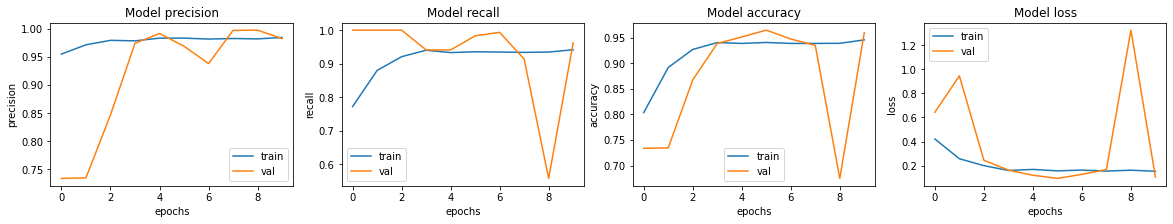

In [ ]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

# 각각 [정밀도, 재현율, 정확도, 오차값] 그래프 출력
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# Loss: 0.6618583798408508,
# Accuracy: 0.7676281929016113,
# Precision: 0.7360308170318604,
# Recall: 0.9794871807098389

# 재현율이 97%로 높게 나왔고
# 정확도와 정밀도가 약 76%, 73%로 다소 낮은 값이 나왔다.

39/39 [==============================] - 5s 117ms/step - loss: 0.6619 - accuracy: 0.7676 - precision: 0.7360 - recall: 0.9795
Loss: 0.6618583798408508,
Accuracy: 0.7676281929016113,
Precision: 0.7360308170318604,
Recall: 0.9794871807098389


In [ ]:
# ----------------------------------------------------------
# 모델 구조 및 하이퍼 파라미터 변경

In [ ]:
# 하이퍼 파라미터 재설정
with tf.device('/GPU:0'):
    model = build_model()

    BATCH_SIZE = 32  # 16-> 32
    EPOCHS = 10  # 동일

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


# 모델 설계
# 함수로 정의
def build_model():
    model = tf.keras.Sequential([
        # 데이터 입력단
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        # Feature Extraction
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        # 여기 추가
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        # 필터 수 조정
        conv_block(64),
        conv_block(128),
        conv_block(256),
        tf.keras.layers.Dropout(0.4),  # 드랍아웃 비율 조정
        conv_block(512),
        tf.keras.layers.Dropout(0.4),


        # classification (MLP)
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model



In [ ]:
# Data augentation - 데이터 증강

# 가우시안 노이즈 추가 함수
def add_gaussian_noise(image, mean=0.0, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)  # 값이 0~1을 벗어나지 않도록 클리핑
    return image

# 데이터 증강 함수
def augment(image, label):
    # 좌우 반전
    image = tf.image.random_flip_left_right(image)

    # 랜덤 회전 (각도는 -30도 ~ +30도 범위에서 무작위 선택)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # 가우시안 노이즈 추가
    image = add_gaussian_noise(image)

    return image, label

# 이미지 전처리 + 데이터 증강 처리
def process_path_with_augmentation(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img, label = augment(img, label)  # 데이터 증강 적용
    return img, label

# Dataset에 적용
train_ag_ds = train_list_ds.map(process_path_with_augmentation, num_parallel_calls=AUTOTUNE)
val_ag_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# 데이터셋을 준비합니다. (shuffle, batch, prefetch 적용)
train_ag_ds = prepare_for_training(train_ag_ds)
val_ag_ds = prepare_for_training(val_ag_ds)



In [ ]:
# 최종으로 수정한 모델fit
with tf.device('/GPU:0'):
    history = model.fit(
        train_ag_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=train_ag_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
130/130 [==============================] - 49s 290ms/step - loss: 0.6606 - accuracy: 0.6438 - precision: 0.8725 - recall: 0.6124 - val_loss: 0.5969 - val_accuracy: 0.7168 - val_precision: 0.7168 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 35s 268ms/step - loss: 0.4307 - accuracy: 0.8024 - precision: 0.9499 - recall: 0.7745 - val_loss: 0.6543 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 3/10
130/130 [==============================] - 37s 286ms/step - loss: 0.4044 - accuracy: 0.8240 - precision: 0.9376 - recall: 0.8198 - val_loss: 0.8546 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/10
130/130 [==============================] - 36s 278ms/step - loss: 0.3271 - accuracy: 0.8644 - precision: 0.9624 - recall: 0.8498 - val_loss: 1.1324 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/10
130/130 [==============================] - 38s 290ms/step - loss: 0.3143 - accura

39/39 [==============================] - 5s 124ms/step - loss: 0.4145 - accuracy: 0.8494 - precision: 0.8318 - recall: 0.9513
Loss: 0.4144650995731354,
Accuracy: 0.8493589758872986,
Precision: 0.8318385481834412,
Recall: 0.9512820243835449


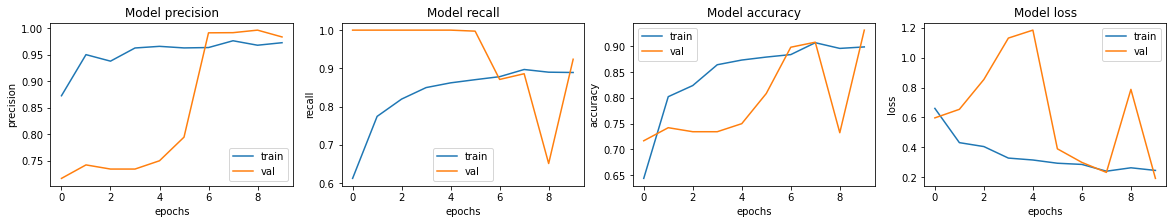

In [ ]:
# 결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

# 각각 [정밀도, 재현율, 정확도, 오차값] 그래프 출력
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
기존 모델
accuracy: 0.7676 - precision: 0.7360 - recall: 0.9795
Loss: 0.6618583798408508,
Accuracy: 0.7676281929016113,
Precision: 0.7360308170318604,
Recall: 0.9794871807098389

데이터 증강 및 수정 모델
accuracy: 0.8494 - precision: 0.8318 - recall: 0.9513
Loss: 0.4144650995731354,
Accuracy: 0.8493589758872986,
Precision: 0.8318385481834412,
Recall: 0.9512820243835449

재현율은 약간 낮아졌으나(-2%p)
정밀도와 정확도는 약 10%p 증가한 것으로 모델의 성능이 개선된 것을 알 수 있다.

In [ ]:
#---------------------------------------------------------

In [ ]:
# Resnet 모델 구현 및 기존 모델과 비교



In [ ]:
#---------------------------------------------------------

In [ ]:
# 회고
데이터 증강 및 다양한 모델 구조 변경을 통해 성능 개선을 확인할 수 있었다.

모델의 성능을 향상시키기 위해 데이터 증강 기법을 사용해도
데이터셋의 특성을 봐가며 알맞게 사용해야 한다는 내용을 봤으나 시간이 없어 직접 확인까지는 못했다.
ex) 가우시안 노이즈 추가
+ resnet도... 해야하는데...;;;

# Reference
- 이전 DeepCV_10 Project
- ChatGPT